# Terrain Classification - Jamie's Power Data
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_power/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Jamie' not in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time',]

In [7]:
# List all datasets
dataset_labels

['Middle_PowerAsphaltDonutJamie_Module6050',
 'Middle_PowerCarpetDonutJamie_Module6050',
 'Middle_PowerGravelF8Jamie_Module6050',
 'Middle_ConcreteF8Jamie_Module6050',
 'Middle_PowerConcreteDonutJamie_Module6050',
 'Middle_PowerGrassF8Jamie_Module6050',
 'Middle_PowerGrassDonutJamie_Module6050',
 'Middle_PowerSidewalkStraightJamie_Module6050',
 'Middle_PowerConcreteStraightJamie_Module6050',
 'Middle_PowerSidewalkF8Jamie_Module6050',
 'Middle_PowerGrassStraightJamie_Module6050',
 'Middle_PowerGravelStraightJamie_Module6050',
 'Middle_PowerAsphaltF8Jamie_Module6050',
 'Middle_PowerSidewalkDonutJamie_Module6050',
 'Middle_PowerGravelDonutJamie_Module6050',
 'Middle_PowerConcreteF8Jamie_Module6050',
 'Middle_PowerLinoleumDonutJamie_Module6050',
 'Middle_PowerCarpetStraightJamie_Module6050',
 'Middle_PowerLinoleumF8Jamie_Module6050',
 'Middle_PowerCarpetF8Jamie_Module6050',
 'Middle_PowerAsphaltStraightJamie_Module6050',
 'Middle_PowerLinoleumStraihtJamie_Module6050']

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
2251,-10.852553,-3.717013,6.353527,-0.727214,-0.452937,0.652054,7.516132,1.565211e+09
2252,0.457850,0.212771,-3.282947,0.237885,0.065973,0.136873,7.520031,1.565211e+09
2253,3.365076,1.481988,1.860976,0.328455,0.197033,0.143000,7.523164,1.565211e+09
2254,4.404397,0.880906,-1.779044,0.051418,-0.004351,0.338524,7.526278,1.565211e+09
2255,-1.668688,0.986275,1.494579,0.057279,-0.037383,0.324672,7.529995,1.565211e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

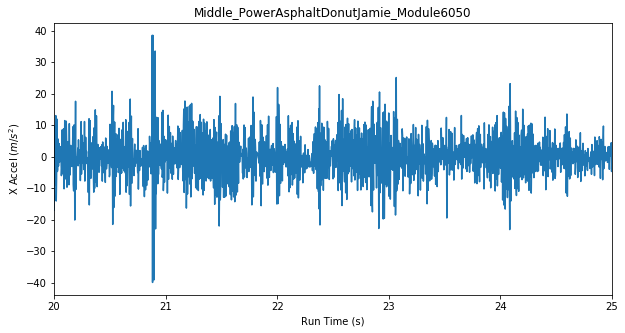

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'X Accel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

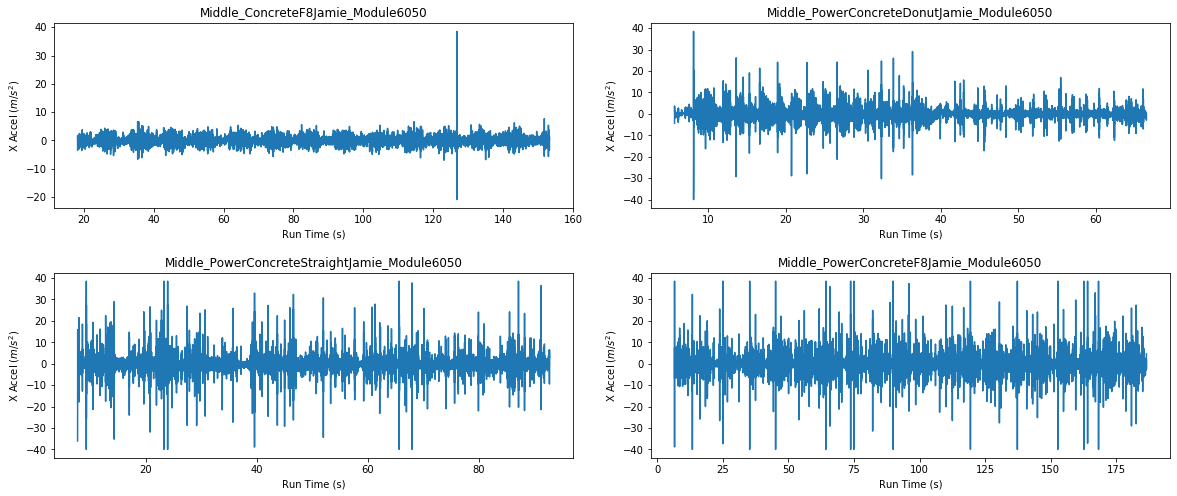

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='X Accel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 22
Shape of first dataset: (18242, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

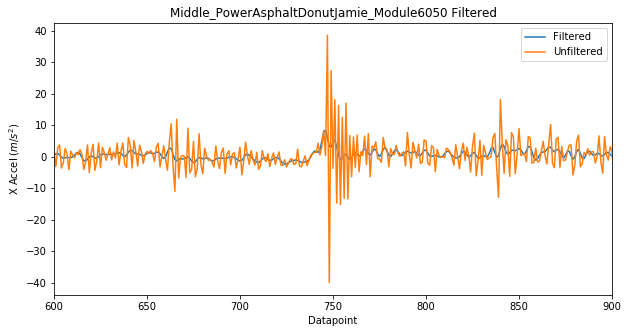

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 22
Shape of first filtered dataset: (18242, 8)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-10.851915,-3.717155,6.353272,-0.727208,-0.452937,0.652055,7.516132,1.565211e+09
1,-2.328919,-0.520003,1.732748,-0.060869,-0.070351,0.331140,7.520031,1.565211e+09
2,3.109253,1.289036,-0.948271,0.286702,0.130366,0.174002,7.523164,1.565211e+09
3,4.622682,1.382058,-1.355486,0.254198,0.115229,0.202871,7.526278,1.565211e+09
4,3.597105,0.601163,-0.600179,0.040610,-0.002474,0.307765,7.529995,1.565211e+09


<Figure size 432x288 with 0 Axes>

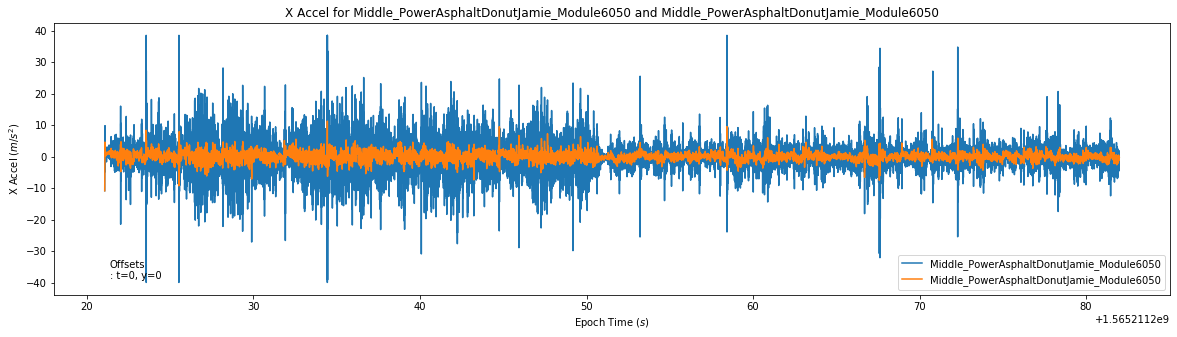

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [31]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''

'\nfor terrain in terrains:\n    for movement in movements:\n        # Identifier at end of label\n        label_suffix = terrain + movement + \'_Module\'\n        \n        # Set index to epoch time for easier time alignment\n        left = datasets[\'Left_\' + label_suffix].set_index(\'Epoch Time\')\n        right = datasets[\'Right_\' + label_suffix].set_index(\'Epoch Time\')\n        middle = datasets[\'Middle_\' + label_suffix + \'6050\'].set_index(\'Epoch Time\')\n        synthesis = datasets[\'Synthesis_\' + label_suffix].set_index(\'Epoch Time\')\n        \n        # Join the wheel data columns, only where they overlap in Epoch Time\n        dataset_wheels = pd.concat([left, right], axis=1, join=\'inner\')\n        dataset_wheels = dataset_wheels.reset_index()\n        \n        # Save as a csv and add to dataset dictionary\n        wheels_label = \'Wheels_\' + label_suffix\n        dataset_wheels.to_csv(\'imu_data/\' + wheels_label + \'.csv\', index=False)\n        datasets.up

In [32]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [33]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [34]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 22
Num of windows in first dataset: 60
Shape of individual window: (300, 8)


In [35]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
295,-0.158363,1.657577,1.584029,0.066156,0.007309,0.894967,8.499989,1.565211e+09
296,-1.525420,1.257292,1.842324,0.108265,0.024068,0.887063,8.503114,1.565211e+09
297,-0.972728,1.359555,1.071779,0.105068,0.033978,0.903171,8.506124,1.565211e+09
298,0.043019,1.481844,0.398558,0.075404,0.037741,0.929708,8.509998,1.565211e+09
299,0.257032,1.183110,0.502675,0.035195,0.047851,0.942342,8.513127,1.565211e+09


<Figure size 432x288 with 0 Axes>

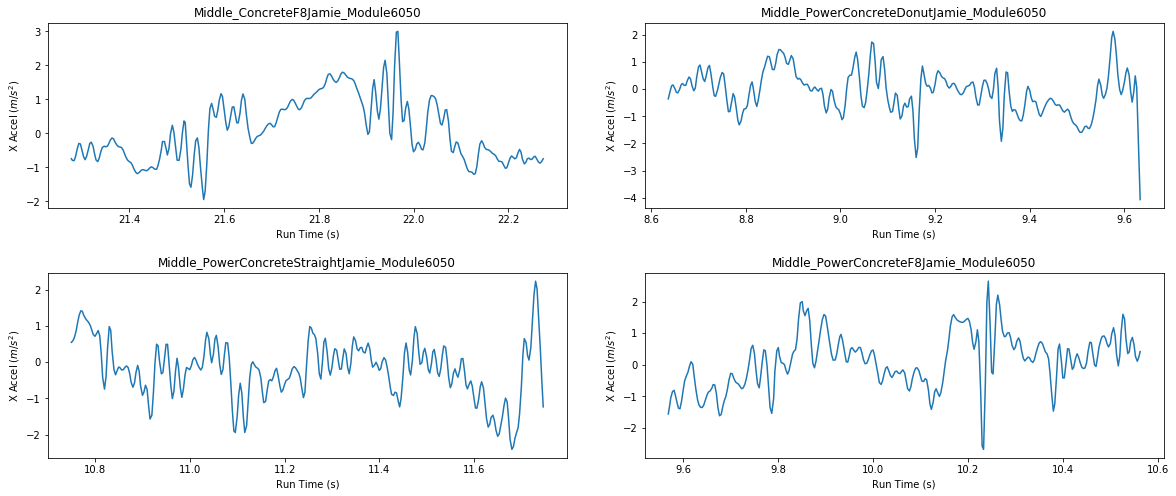

In [36]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='X Accel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [37]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [38]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [39]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 22
Num of FFT'd windows in first dataset: 59
Shape of FFT'd individual window: (60, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.561475,0.715253,0.063875,0.020472,0.015163,0.693195,0.0
1,0.343365,0.161041,0.019585,0.002759,0.008696,0.106799,1.0
2,0.144715,0.084609,0.033696,0.007233,0.002987,0.046451,2.0
3,0.094928,0.012753,0.035953,0.003180,0.007558,0.021977,3.0
4,0.065259,0.012980,0.038508,0.002232,0.003495,0.013960,4.0


<Figure size 432x288 with 0 Axes>

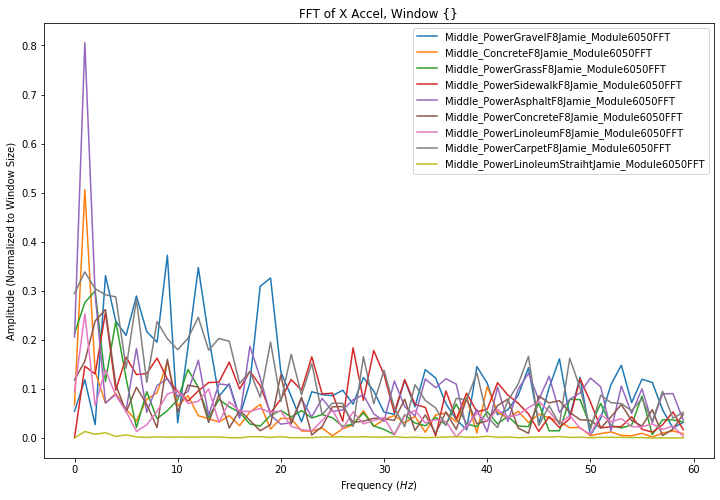

In [42]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

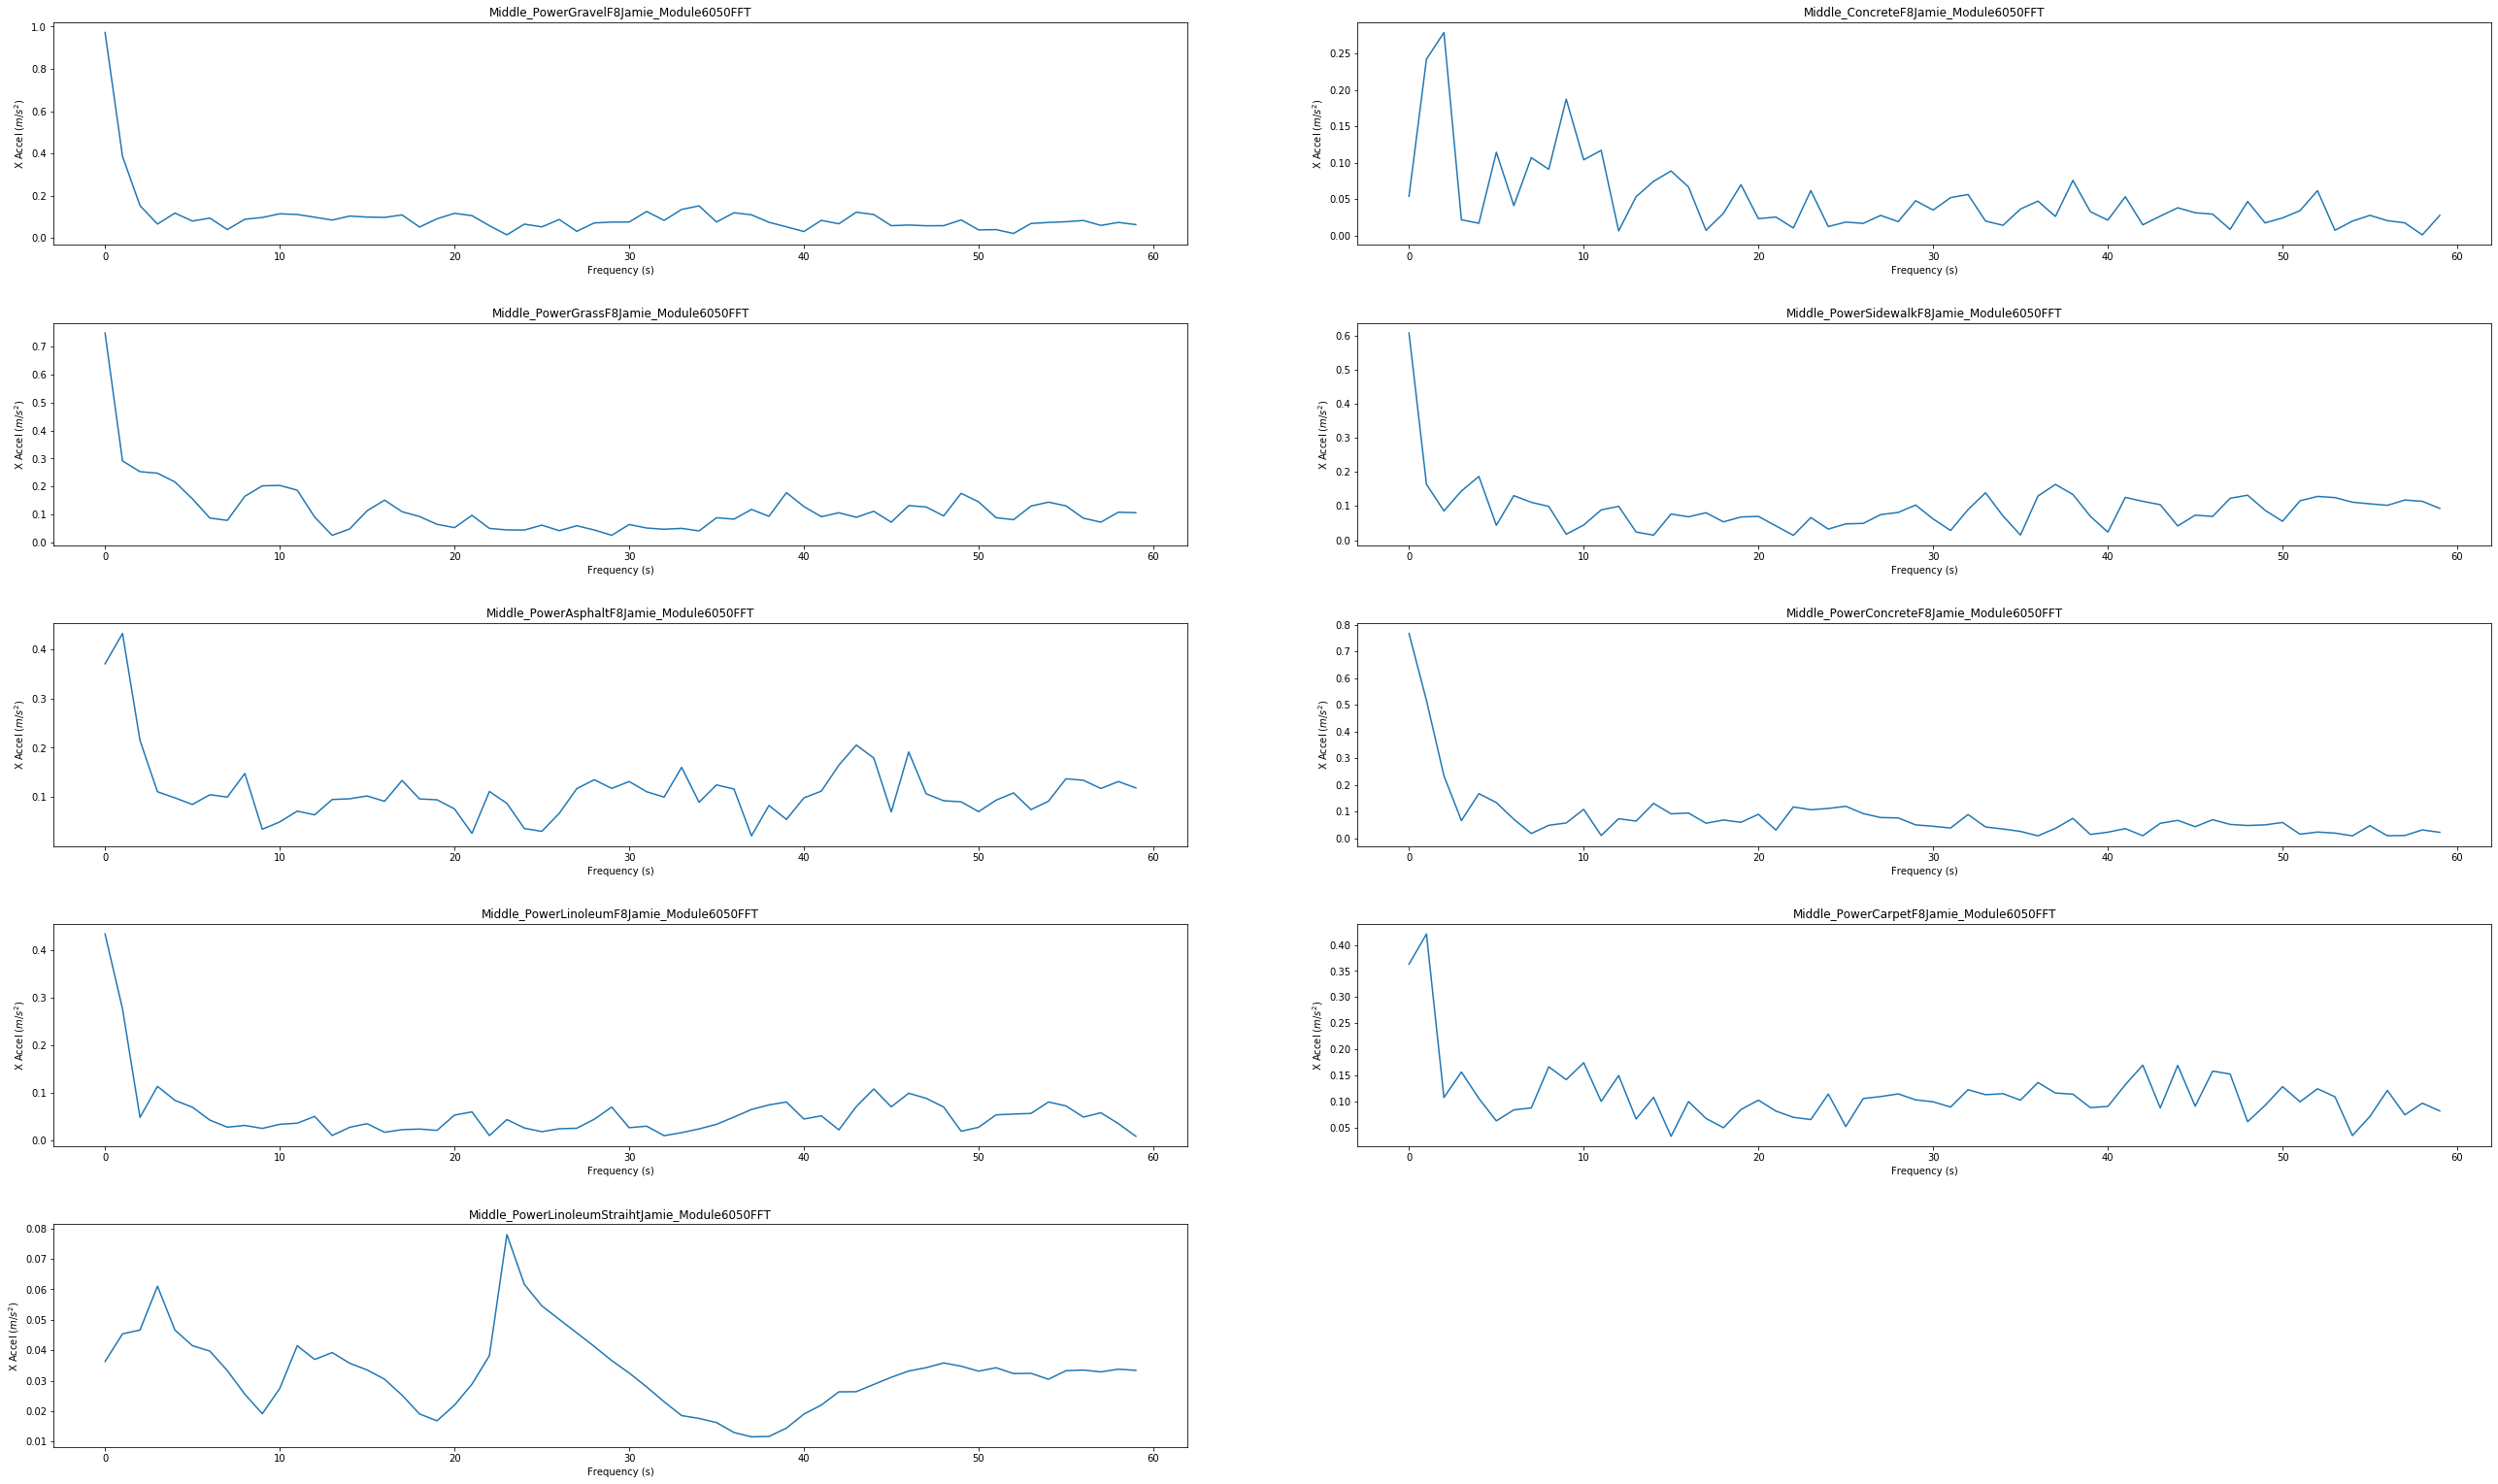

In [43]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

### Part (b) - PSD

In [44]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [45]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 22
Num of PSD'd windows in first dataset: 60
Shape of PSD'd individual window: (60, 7)


<Figure size 432x288 with 0 Axes>

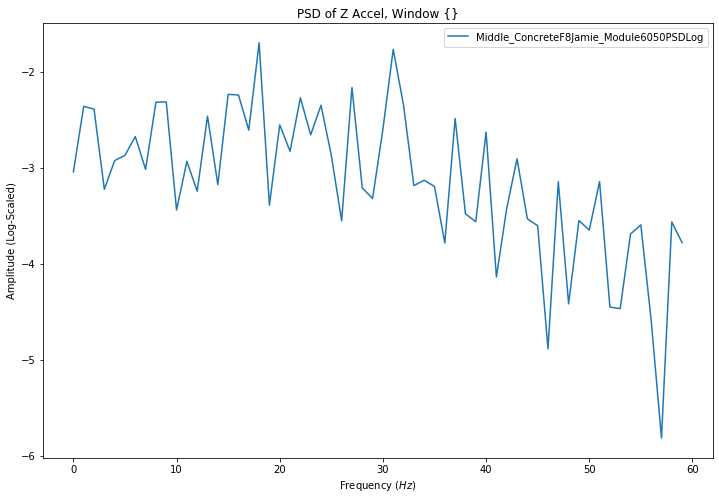

In [48]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

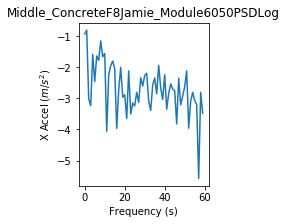

In [49]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [50]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

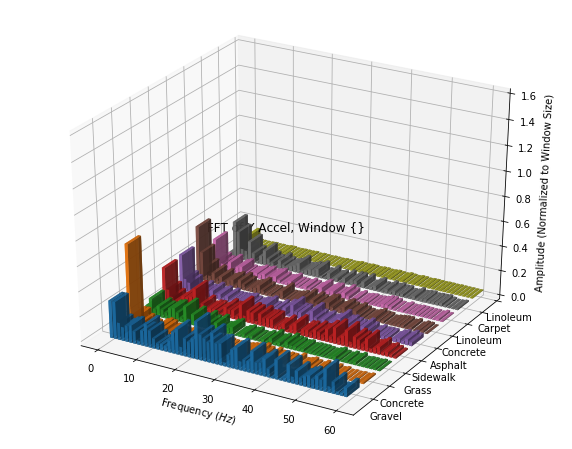

In [51]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

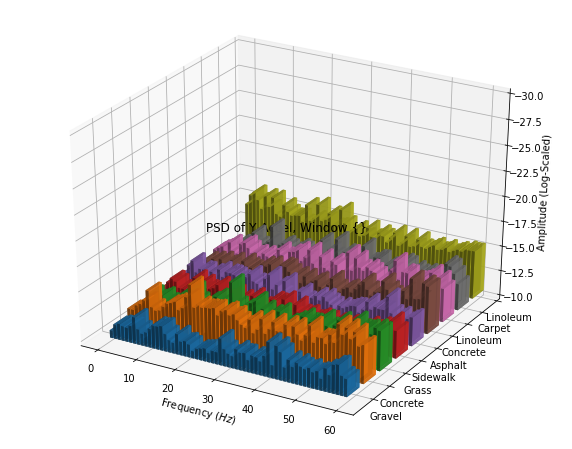

In [52]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [53]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

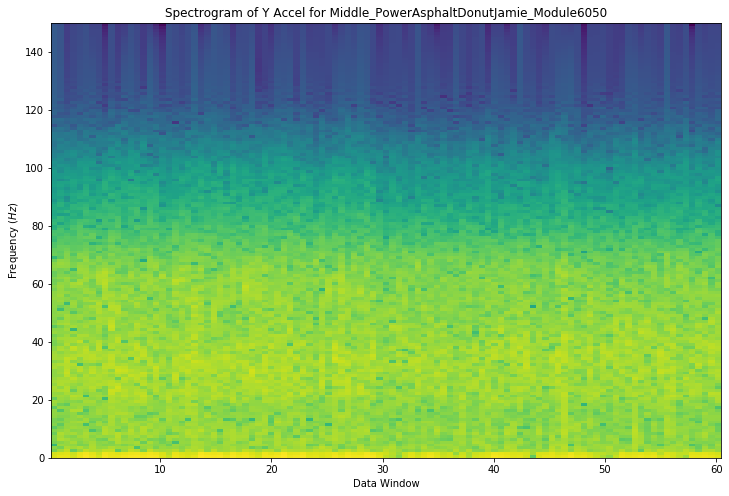

In [54]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [55]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [56]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [57]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [58]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [59]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 22
Num directions: 6
Shape of first dataset first direction: (60, 10)


<Figure size 432x288 with 0 Axes>

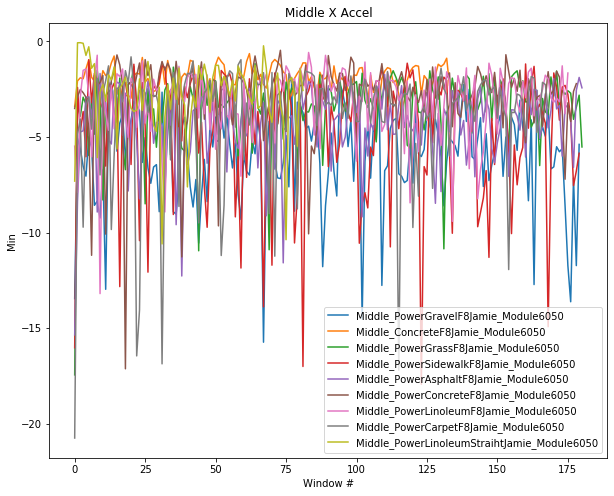

In [60]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [61]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [62]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 22
Num directions: 6
Shape of one direction: (60, 5)


<Figure size 432x288 with 0 Axes>

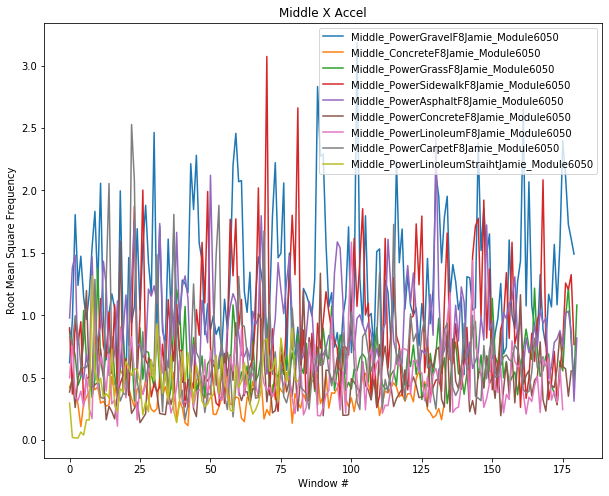

In [63]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [64]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [65]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [66]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [67]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,0.561475,1.317957,24.812896,615.679790,4.716016,-10.851915,1.432573,0.110000,-2.549767,19.387016,1.023424,1.011644,24.580077,-603.156765,1.011644
1,0.163651,1.165644,20.387549,415.652144,2.640282,-3.680374,1.177076,0.176667,-0.566794,0.115022,0.668711,0.817747,20.761192,-430.358389,0.817747
2,0.572435,1.455557,27.090559,733.898368,8.351854,-2.471612,1.564074,0.126667,1.269186,4.410809,0.818196,0.904542,16.666849,-276.965660,0.904542
3,0.337809,1.155822,20.856932,435.011627,4.041621,-2.502797,1.204176,0.186667,0.305654,-0.101514,0.576287,0.759136,17.697075,-312.610162,0.759136
4,0.330963,1.756149,30.952844,958.078574,7.961998,-9.280557,1.787063,0.150000,-0.403917,4.669365,2.091277,1.446125,25.348929,-640.476914,1.446125


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [68]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [69]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [70]:
datasets_feat_norm[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,1.823351,0.289202,0.516626,0.406852,0.185466,-3.799366,0.516626,-2.020280,-4.346200,5.970310,0.138646,0.311161,1.004692,-1.047222,0.311161
1,0.482793,-0.152064,-0.220715,-0.345026,-0.843115,0.102010,-0.220715,0.497203,-1.112159,-0.504160,-0.417062,-0.279999,0.064957,0.033505,-0.279999
2,1.860284,0.687840,0.896125,0.851220,1.987118,0.759585,0.896125,-1.390909,1.882149,0.939020,-0.182873,-0.015377,-0.942562,0.992864,-0.015377
3,1.069657,-0.180519,-0.142507,-0.272256,-0.148715,0.742621,-0.142507,0.874825,0.310720,-0.576905,-0.561857,-0.458697,-0.689048,0.769933,-0.458697
4,1.046589,1.558682,1.539650,1.693884,1.793935,-2.944535,1.539650,-0.509790,-0.846523,1.025882,1.811588,1.635824,1.193888,-1.280632,1.635824


<Figure size 432x288 with 0 Axes>

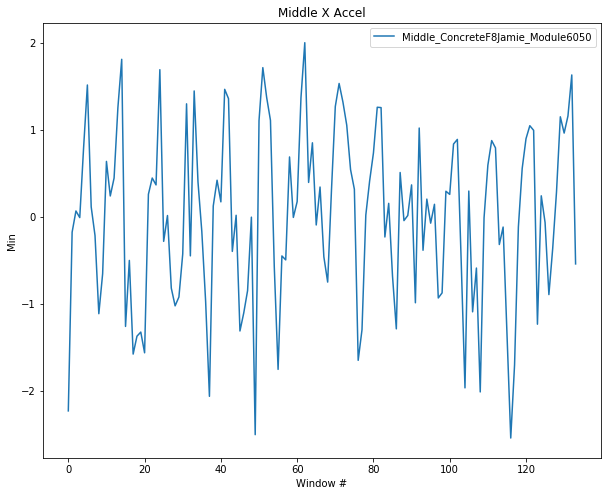

In [71]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

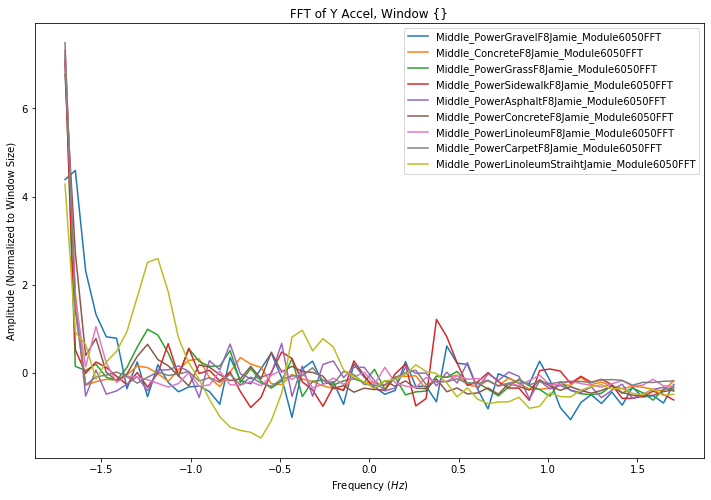

In [72]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [73]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [74]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [75]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,Excess Kurtosis X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,1.823351,0.289202,0.516626,0.406852,0.185466,-3.799366,0.516626,-2.020280,-4.346200,5.970310,...,0.663373,-1.066009,-0.158511,-0.948490,0.047550,-0.324242,-0.149364,1.321064,-0.951186,-0.149364
1,0.482793,-0.152064,-0.220715,-0.345026,-0.843115,0.102010,-0.220715,0.497203,-1.112159,-0.504160,...,0.721239,-0.705568,-0.158511,-0.973127,-0.722660,-0.471480,-0.420764,-0.056212,0.256459,-0.420764
2,1.860284,0.687840,0.896125,0.851220,1.987118,0.759585,0.896125,-1.390909,1.882149,0.939020,...,0.185258,-1.827641,7.450001,0.576485,0.027352,0.470225,0.813645,0.195095,0.100310,0.813645
3,1.069657,-0.180519,-0.142507,-0.272256,-0.148715,0.742621,-0.142507,0.874825,0.310720,-0.576905,...,1.229306,0.630777,-0.158511,0.158643,-1.205087,-0.702801,-1.168784,-1.049146,0.599329,-1.168784
4,1.046589,1.558682,1.539650,1.693884,1.793935,-2.944535,1.539650,-0.509790,-0.846523,1.025882,...,0.759541,-0.698585,-0.158511,0.369367,0.286604,-0.661056,-0.947558,-0.203733,0.335233,-0.947558


#### Part (ii) - Transformed Data

In [76]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [77]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [78]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [79]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,FFT 58.0 Hz Z Accel Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,0.001769,0.002231,0.003896,0.050312,0.009269,0.130071,0.002178,0.001643,0.003799,0.034483,...,0.002759,0.019585,0.161041,0.343365,0.693195,0.015163,0.020472,0.063875,0.715253,0.561475
1,0.002895,0.001300,0.000802,0.011211,0.027865,0.008755,0.002578,0.002103,0.001208,0.027385,...,0.013866,0.032705,0.235738,0.377885,0.759616,0.029756,0.023442,0.016154,1.066553,0.163651
2,0.003197,0.002377,0.002568,0.043160,0.041151,0.094423,0.002848,0.002406,0.001612,0.103560,...,0.007937,0.033321,0.267187,0.388864,0.373398,0.003674,0.018997,0.045347,0.794452,0.572435
3,0.000682,0.001217,0.001557,0.015758,0.022467,0.028390,0.001220,0.001300,0.002112,0.012512,...,0.006021,0.049242,0.329990,0.251798,1.109562,0.037453,0.028328,0.109546,1.664699,0.337809
4,0.000477,0.001993,0.002927,0.037388,0.027601,0.100200,0.002250,0.002256,0.002518,0.022160,...,0.003885,0.069098,0.252002,0.557520,0.769716,0.015865,0.015851,0.052114,0.865003,0.330963
5,0.001424,0.001180,0.001814,0.029421,0.023812,0.067074,0.002053,0.001868,0.001677,0.016642,...,0.017281,0.039986,0.279749,0.149084,1.146227,0.059686,0.033413,0.132789,1.384655,0.166854
6,0.001016,0.002282,0.003351,0.037208,0.058149,0.173661,0.001378,0.003130,0.001959,0.057537,...,0.003275,0.124253,0.130740,0.313482,0.950288,0.019692,0.026975,0.049429,1.339420,0.269287
7,0.000508,0.000323,0.000312,0.004480,0.025129,0.013118,0.000449,0.001067,0.002005,0.020923,...,0.009618,0.076085,0.329385,0.302408,1.222722,0.036276,0.044105,0.008131,2.017607,0.030706
8,0.000632,0.000415,0.002165,0.059050,0.045272,0.100058,0.001114,0.000748,0.001151,0.037392,...,0.012108,0.112375,0.070686,0.122899,0.791962,0.020346,0.015428,0.005789,1.457950,0.123095
9,0.001176,0.000814,0.002375,0.010802,0.051718,0.054120,0.000611,0.001504,0.003482,0.013768,...,0.008676,0.079586,0.251967,0.310457,1.135606,0.045824,0.043276,0.081469,1.788088,0.330452


In [80]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,PSD 58.0 Hz Z Accel Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
0,-5.048204,-5.703582,-4.395937,-2.843978,-2.438024,-2.699852,-5.203424,-5.001892,-4.517724,-2.295629,...,-3.980307,-2.643809,-1.844138,-1.377942,-1.641833,-3.820301,-4.817314,-3.115107,-1.285098,-0.627457
1,-4.742454,-5.540156,-4.908957,-3.783118,-2.296803,-2.213624,-4.775627,-5.470938,-5.890250,-3.599711,...,-3.742543,-3.084963,-2.027551,-1.055697,-1.211856,-3.539395,-3.415072,-2.669741,-0.954112,-0.544251
2,-5.246679,-5.051751,-4.490819,-1.746224,-1.854583,-1.525638,-4.689458,-4.946891,-4.879936,-2.428804,...,-4.348777,-2.838685,-1.632096,-1.075552,-0.968994,-3.203934,-3.899684,-2.653536,-0.845340,-0.519374
3,-5.847119,-5.973349,-5.547534,-2.847150,-3.002894,-1.849522,-6.031922,-5.528494,-5.314500,-3.303985,...,-4.263985,-3.174207,-2.349189,-0.739855,-1.187007,-3.714829,-4.139630,-2.314303,-0.661968,-0.896865
4,-5.688299,-5.872563,-5.115822,-3.059172,-2.671766,-2.176802,-6.342830,-5.100075,-4.766228,-2.553503,...,-3.658909,-1.611584,-1.681399,-1.179146,-1.252056,-3.221682,-4.520239,-2.020038,-0.896162,-0.206448
5,-4.875947,-6.594684,-4.295078,-3.877937,-1.663232,-2.499794,-5.392169,-5.555332,-5.181656,-2.761642,...,-3.517331,-2.000831,-0.994465,-1.010784,-0.948212,-3.003217,-3.223811,-2.495153,-0.805432,-1.352105
6,-6.034883,-6.113580,-5.343553,-2.804510,-3.506971,-1.930712,-5.684948,-4.982429,-4.648665,-2.557704,...,-4.150870,-1.952675,-2.006125,-0.918679,-2.222015,-2.992106,-4.668586,-1.510355,-1.466156,-0.706545
7,-5.962042,-6.248952,-5.304110,-2.861174,-3.907014,-2.348384,-6.287078,-6.679379,-6.709831,-4.396418,...,-3.721244,-2.320390,-1.848017,-1.192482,-1.617205,-3.745792,-3.732819,-1.936370,-0.663561,-0.737785
8,-6.186140,-5.133146,-4.757990,-2.677543,-2.720070,-1.845712,-6.097680,-6.463813,-5.028167,-2.156525,...,-4.469010,-1.775076,-2.397075,-0.875907,-3.429483,-3.114672,-3.532845,-1.597628,-2.000299,-1.519875
9,-5.769882,-5.482882,-4.604705,-2.550763,-2.298374,-1.631087,-5.558319,-5.877294,-4.947626,-3.631989,...,-4.190078,-1.961074,-1.448467,-0.693431,-1.436799,-3.950320,-3.822310,-1.897296,-0.896283,-0.714968


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [81]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [82]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [83]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,3,1.823351,0.289202,0.516626,0.406852,0.185466,-3.799366,0.516626,-2.020280,-4.346200,...,0.663373,-1.066009,-0.158511,-0.948490,0.047550,-0.324242,-0.149364,1.321064,-0.951186,-0.149364
1,3,0.482793,-0.152064,-0.220715,-0.345026,-0.843115,0.102010,-0.220715,0.497203,-1.112159,...,0.721239,-0.705568,-0.158511,-0.973127,-0.722660,-0.471480,-0.420764,-0.056212,0.256459,-0.420764
2,3,1.860284,0.687840,0.896125,0.851220,1.987118,0.759585,0.896125,-1.390909,1.882149,...,0.185258,-1.827641,7.450001,0.576485,0.027352,0.470225,0.813645,0.195095,0.100310,0.813645
3,3,1.069657,-0.180519,-0.142507,-0.272256,-0.148715,0.742621,-0.142507,0.874825,0.310720,...,1.229306,0.630777,-0.158511,0.158643,-1.205087,-0.702801,-1.168784,-1.049146,0.599329,-1.168784
4,3,1.046589,1.558682,1.539650,1.693884,1.793935,-2.944535,1.539650,-0.509790,-0.846523,...,0.759541,-0.698585,-0.158511,0.369367,0.286604,-0.661056,-0.947558,-0.203733,0.335233,-0.947558


In [84]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,3,0.001769,0.002231,0.003896,0.050312,0.009269,0.130071,0.002178,0.001643,0.003799,...,0.002759,0.019585,0.161041,0.343365,0.693195,0.015163,0.020472,0.063875,0.715253,0.561475
1,3,0.002895,0.001300,0.000802,0.011211,0.027865,0.008755,0.002578,0.002103,0.001208,...,0.013866,0.032705,0.235738,0.377885,0.759616,0.029756,0.023442,0.016154,1.066553,0.163651
2,3,0.003197,0.002377,0.002568,0.043160,0.041151,0.094423,0.002848,0.002406,0.001612,...,0.007937,0.033321,0.267187,0.388864,0.373398,0.003674,0.018997,0.045347,0.794452,0.572435
3,3,0.000682,0.001217,0.001557,0.015758,0.022467,0.028390,0.001220,0.001300,0.002112,...,0.006021,0.049242,0.329990,0.251798,1.109562,0.037453,0.028328,0.109546,1.664699,0.337809
4,3,0.000477,0.001993,0.002927,0.037388,0.027601,0.100200,0.002250,0.002256,0.002518,...,0.003885,0.069098,0.252002,0.557520,0.769716,0.015865,0.015851,0.052114,0.865003,0.330963


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [85]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [86]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [88]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Jamie_Power')

feat_combined['Middle'].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
2404,2,0.181247,0.061376,-0.265917,-0.461367,-0.046063,0.470907,-0.265917,0.299904,0.448711,...,0.178872,-0.213150,-0.531546,1.661023,0.500482,0.469433,0.832349,0.345119,0.006166,0.832349
2405,2,0.426532,0.555680,0.196672,-0.014523,0.929218,-0.027480,0.196672,0.813769,0.464374,...,0.125001,-0.482736,2.453847,-0.907695,1.890069,0.310212,0.687875,0.324850,0.019620,0.687875
2406,2,-0.301364,1.314784,0.814216,0.725939,1.636959,-1.432306,0.814216,0.593541,0.361209,...,0.118386,-0.466075,1.558229,-1.643279,1.234809,0.763210,1.074691,0.507603,-0.108925,1.074691
2407,2,-0.143202,-0.439745,-0.684242,-0.785936,-0.308008,0.712705,-0.684242,0.960587,0.625883,...,0.736331,-0.537397,-0.233006,-0.056619,-0.979402,-0.646114,-0.841166,-0.686667,0.474753,-0.841166
2408,2,-0.747243,-0.077553,-0.143647,-0.352238,-0.242066,0.111964,-0.143647,0.593541,0.101632,...,0.099114,-0.486545,0.662612,-1.150534,0.934263,-0.457282,-0.294748,1.055433,-0.582022,-0.294748


In [89]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Jamie_Power')

fft_combined['Middle'].tail()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
2404,2,0.003663,0.001072,0.000989,0.006949,0.003087,0.022316,0.003913,0.000660,0.001184,...,0.007080,0.019097,0.345175,0.181796,0.149483,0.003417,0.007889,0.012695,0.051930,0.082681
2405,2,0.001285,0.000327,0.002252,0.013385,0.016537,0.021763,0.002389,0.001097,0.001695,...,0.006473,0.027451,0.210484,0.162555,0.011923,0.000598,0.000609,0.013932,0.123544,0.215031
2406,2,0.001490,0.001219,0.001505,0.055456,0.005134,0.052839,0.000811,0.001870,0.002868,...,0.009196,0.160560,0.093918,0.205604,0.168826,0.017393,0.007765,0.266802,0.171114,0.177724
2407,2,0.000708,0.001016,0.000748,0.013870,0.016820,0.015743,0.000960,0.001066,0.000394,...,0.009450,0.042723,0.220663,0.179265,0.138424,0.003020,0.012386,0.036039,0.378420,0.092384
2408,2,0.002165,0.000801,0.001504,0.005459,0.027881,0.033007,0.002293,0.000732,0.000958,...,0.007633,0.017351,0.104716,0.094863,0.167268,0.009923,0.002552,0.012416,0.068768,0.418310


In [90]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Jamie_Power')

psd_log_combined['Middle'].tail()

,Label,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
2404,2,-4.639189,-5.977871,-5.685226,-4.195538,-3.689836,-3.312702,-4.571339,-5.638389,-5.708419,...,-3.953291,-3.809863,-1.337522,-1.249373,-1.085248,-3.390541,-3.998851,-3.137055,-0.622890,-1.179803
2405,2,-5.702885,-5.994705,-6.104667,-3.960221,-3.476781,-3.265819,-5.480953,-6.668913,-4.993792,...,-4.808866,-2.846585,-0.962022,-1.555995,-1.654917,-3.122711,-4.076803,-2.821863,-1.052531,-1.276969
2406,2,-5.676570,-4.923707,-5.292585,-2.576326,-3.635089,-2.414147,-5.352392,-5.526866,-5.343678,...,-3.731575,-0.968770,-0.943446,-1.183642,-2.112424,-4.200643,-3.771750,-1.287697,-1.753470,-1.072905
2407,2,-5.898734,-6.790325,-6.371334,-3.432586,-4.191689,-3.661720,-5.998635,-5.684935,-5.951226,...,-4.989396,-3.424777,-1.829965,-1.693074,-1.786726,-3.693914,-3.748139,-2.437649,-1.011513,-1.191977
2408,2,-5.031388,-6.717666,-5.521333,-4.045816,-3.404194,-2.348229,-5.028234,-5.891845,-5.344342,...,-4.173503,-3.413935,-4.612961,-1.063686,-1.863359,-3.643496,-3.933624,-3.220311,-1.658942,-1.744775


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right